In [14]:
import pymc3 as pm
import theano.tensor as tt
import scipy.stats as stats
from IPython.core.pylabtools import figsize
%matplotlib inline

## An algorithm for human deceit

Social data has an additional layer of interest as people are not always honest with responses, which adds a further complication into inference. For example, simply asking individuals "Have you ever cheated on a test?" will surely contain some rate of dishonesty. What you can say for certain is that the true rate is less than your observed rate (assuming individuals lie *only* about *not cheating*; I cannot imagine one who would admit "Yes" to cheating when in fact they hadn't cheated).

#### Cheating among students

We will use the binomial distribution to determine the frequency of students cheating during an exam. If we let $N$ be the total number of students who took the exam, and assuming each student is interviewed post-exam (answering without consequence), we will receive integer $X$ "Yes I did cheat" answers. We then find the posterior distribution of $p$, given $N$, some specified prior on $p$, and observed data $X$. 

This is a completely absurd model. No student, even with a free-pass against punishment, would admit to cheating. What we need is a better *algorithm* to ask students if they had cheated. Ideally the algorithm should encourage individuals to be honest while preserving privacy. The following proposed algorithm is a solution I greatly admire for its ingenuity and effectiveness:

> In the interview process for each student, the student flips a coin, hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again, and answers "Yes, I did cheat" if the coin flip lands heads, and "No, I did not cheat", if the coin flip lands tails. This way, the interviewer does not know if a "Yes" was the result of a guilty plea, or a Heads on a second coin toss. Thus privacy is preserved and the researchers receive honest answers. 

I call this the Privacy Algorithm. One could of course argue that the interviewers are still receiving false data since some *Yes*'s are not confessions but instead randomness, but an alternative perspective is that the researchers are discarding approximately half of their original dataset since half of the responses will be noise. But they have gained a systematic data generation process that can be modeled. Furthermore, they do not have to incorporate (perhaps somewhat naively) the possibility of deceitful answers. We can use PyMC3 to dig through this noisy model, and find a posterior distribution for the true frequency of liars. 

Suppose 100 students are being surveyed for cheating, and we wish to find $p$, the proportion of cheaters. There are a few ways we can model this in PyMC3. Both versions arrive at the same inference. In our data-generation model, we sample $p$, the true proportion of cheaters, from a prior. Since we are quite ignorant about $p$, we will assign it a $\text{Uniform}(0,1)$ prior.

In [2]:
N = 100

with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1)

Again, thinking of our data-generation model, we assign Bernoulli random variables to the 100 students: 1 implies they cheated and 0 implies they did not. 

In [3]:
with model:
    true_answers = pm.Bernoulli('truths', p, shape=N, 
                                testval=np.random.binomial(1, .5, N))

If we carry out the algorithm, the next step that occurs is the first coin-flip each student makes. This can be modeled again by sampling 100 Bernoulli random variables with $p=1/2$: denote a 1 as a *Heads* and 0 a *Tails*.

In [4]:
with model:
    first_coin_flips = pm.Bernoulli('first_flips', .5, shape=N, 
                                    testval=np.random.binomial(1, .5, N))

Although *not everyone* flips a second time, we can still model the possible realization of second coin-flips:

In [5]:
with model:
    second_coin_flips = pm.Bernoulli('second_flips', .5, shape=N, 
                                     testval=np.random.binomial(1, .5, N))

Using these variables, we can return a possible realization of the *observed proportion* of "Yes" responses. We do this using a PyMC3 `deterministic` variable:

In [7]:
with model:
    val = first_coin_flips * true_answers + (1 - first_coin_flips) * second_coin_flips
    observed_proportion = pm.Deterministic(
        'observed_proportion', tt.sum(val) / float(N))

The line `fc*t_a + (1-fc)*sc` contains the heart of the Privacy algorithm. Elements in this array are 1 *if and only if* i) the first toss is heads and the student cheated or ii) the first toss is tails, and the second is heads, and are 0 else. Finally, the last line sums this vector and divides by `float(N)`, produces a proportion. 

Next we need a dataset. After performing our coin-flipped interviews the researchers received 35 "Yes" responses. To put this into a relative perspective, if there truly were no cheaters, we should expect to see on average 1/4 of all responses being a "Yes" (half chance of having first coin land Tails, and another half chance of having second coin land Heads), so about 25 responses in a cheat-free world. On the other hand, if *all students cheated*, we should expected to see approximately 3/4 of all responses be "Yes". 

The researchers observe a Binomial random variable, with `N = 100` and `p = observed_proportion` with `value = 35`:  

In [8]:
X = 35

with model:
    observations = pm.Binomial('obs', N, observed_proportion, observed=X)

In [9]:
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40_000, step=step)
    burned_trace = trace[15_000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]
Sampling 2 chains, 0 divergences: 100%|██████████| 81000/81000 [37:27<00:00, 36.04draws/s]  
The number of effective samples is smaller than 10% for some parameters.


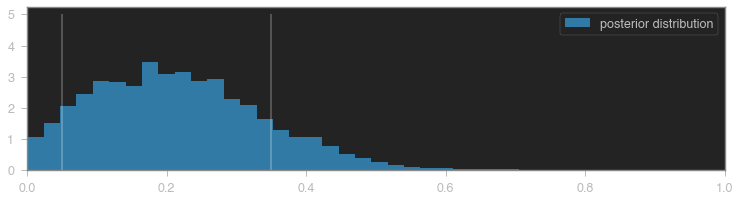

In [15]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"][15_000:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3, colors='white')
plt.xlim(0, 1)
plt.legend();

With regards to the above plot, we are still pretty uncertain about what the true frequency of cheaters might be, but we have narrowed it down to a range between 0.05 to 0.35 (marked by the solid lines). This is pretty good, as *a priori* we had no idea how many students might have cheated (hence the uniform distribution for our prior). On the other hand, it is also pretty bad since there is a .3 length window the true value most likely lives in. Have we even gained anything, or are we still too uncertain about the true frequency? 

I would argue, yes, we have discovered something. It is implausible, according to our posterior, that there are *no cheaters*, i.e. the posterior assigns low probability to $p=0$. Since we started with an uniform prior, treating all values of $p$ as equally plausible, but the data ruled out $p=0$ as a possibility, we can be confident that there were cheaters. 

This kind of algorithm can be used to gather private information from users and be *reasonably* confident that the data, though noisy, is truthful. 

### Alternative PyMC3 Model

Given a value for $p$ (which from our god-like position we know), we can find the probability the student will answer yes: 

\begin{align}
P(\text{"Yes"}) = & P( \text{Heads on first coin} )P( \text{cheater} ) + P( \text{Tails on first coin} )P( \text{Heads on second coin} ) \\\\
& = \frac{1}{2}p + \frac{1}{2}\frac{1}{2}\\\\
& = \frac{p}{2} + \frac{1}{4}
\end{align}

Thus, knowing $p$ we know the probability a student will respond "Yes". In PyMC3, we can create a deterministic function to evaluate the probability of responding "Yes", given $p$:

In [16]:
with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1)
    p_skewed = pm.Deterministic('p_skewed', .5*p + .25)

I could have typed `p_skewed  = 0.5*p + 0.25` instead for a one-liner, as the elementary operations of addition and scalar multiplication will implicitly create a `deterministic` variable, but I wanted to make the deterministic boilerplate explicit for clarity's sake. 

If we know the probability of respondents saying "Yes", which is `p_skewed`, and we have $N=100$ students, the number of "Yes" responses is a binomial random variable with parameters `N` and `p_skewed`.

This is where we include our observed 35 "Yes" responses. In the declaration of the `pm.Binomial`, we include `value = 35` and `observed = True`.

In [17]:
with model:
    yes_responses = pm.Binomial('number_cheaters', 100, p_skewed, observed=35)

In [18]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(25_000, step=step)
    burned_trace = trace[2500:]

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [freq_cheating]
Sampling 2 chains, 0 divergences: 100%|██████████| 51000/51000 [00:16<00:00, 3004.77draws/s]
The number of effective samples is smaller than 25% for some parameters.


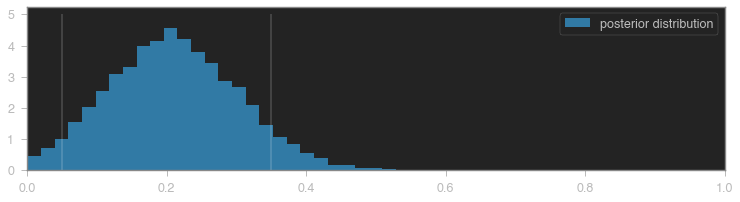

In [20]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2, colors='white')
plt.xlim(0, 1)
plt.legend();